# Neural network in Keras

In [1]:
import tensorflow as tf
import keras
import numpy as np
from keras_experiments import test_model

from speech2phone.preprocessing.TIMIT.phones import get_data
from speech2phone.preprocessing.filters import mel

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
print(tf.__version__)
print(keras.__version__)
print(keras.backend.tensorflow_backend._get_available_gpus())

1.13.1
2.2.4
['/job:localhost/replica:0/task:0/device:GPU:0']


In [4]:
# import data
X, y = get_data(preprocessor=mel, TIMIT_root='../TIMIT/TIMIT', padding=500)

Loading train/mel/500 set from cache... done.


## Model testing

I ran `fashionMNIST_keras.py` to optimize over different hyperparameters. Each model was tested against a validation set. Here I'll retrain the best one on the entire train set and then test on the test set. For each model tested, you can see loss and accuracy plots in `training/`. In `training/results.txt`, each accuracy is recorded with the time it took to train and the parameters used.

In [4]:
!head training/results.txt

0.8843333333333333: [52.992098331451416, [[300, 100], 0.01, 1e-06, 0.8, 10, 32]]
0.8813333333333333: [27.61763858795166, [[300, 100], 0.01, 1e-06, 0.8, 10, 64]]
0.8831666666666667: [53.00431823730469, [[300, 100], 0.01, 1e-06, 0.8, 20, 32]]
0.8859166666666667: [27.37276005744934, [[300, 100], 0.01, 1e-06, 0.8, 20, 64]]
0.8708333333333333: [52.912421464920044, [[300, 100], 0.01, 1e-06, 0.0, 10, 32]]
0.85925: [28.101712942123413, [[300, 100], 0.01, 1e-06, 0.0, 10, 64]]
0.857: [53.98668551445007, [[300, 100], 0.01, 1e-06, 0.0, 20, 32]]
0.8593333333333333: [28.364768743515015, [[300, 100], 0.01, 1e-06, 0.0, 20, 64]]
0.8818333333333334: [54.474355936050415, [[300, 100], 0.01, 0.0, 0.8, 10, 32]]
0.88075: [28.612680196762085, [[300, 100], 0.01, 0.0, 0.8, 10, 64]]


We can decide how important training time is by writing an expression including both training time and accuracy.

In [5]:
results = {}
with open('training/results.txt') as infile:
    for line in infile:
        acc = float(line.split(': [')[0])
        time = float(line.split(': [')[1].split(', [')[0])
        params = line.split(', [')[1].strip()[:-2]  # remove final ']]'
        results[(acc, time)] = params
        
# compute mean and variance of time
times = []
for acc, time in results:
    times.append(time)
t_mean = np.mean(times)
t_sd = np.sqrt(np.var(times))

In [6]:
# we choose to count a decrease in time by 1 standard deviation as equivalent to
# a 1% increase in accuracy
opt = lambda a, t: a - 0.01 * (t - t_mean) / t_sd

In [7]:
best = 0
params = None
for acc, time in results:
    val = opt(acc, time)
    if val > best:
        best = val
        params = results[(acc, time)]
print(best, ':', params)

0.901355607004134 : [300, 100], 0.01, 1e-06, 0.8, 20, 64


For interest's sake, let's check the top performing one (regardless of training time)

In [8]:
best = 0
params = None
for acc, time in results:
    if acc > best:
        best = acc
        params = results[(acc, time)]
print(best, ':', params)

0.8904166666666666 : [300, 300], 0.01, 0.0, 0.8, 10, 32


## Replicating the results

Now train a new network with the same parameters.

In [9]:
widths = [300, 100]  # widths of each hidden layer
lr = 0.01
decay = 1e-6
momentum = 0.8
epochs = 10  # I accidentally produced `results.txt` with epochs=10 always, and 20 does worse
batch_size = 64

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 4s 65us/step - loss: 0.6061 - acc: 0.7929 - val_loss: 0.5034 - val_acc: 0.8168
Epoch 2/10
60000/60000 [==============================] - 3s 57us/step - loss: 0.4249 - acc: 0.8494 - val_loss: 0.4266 - val_acc: 0.8468
Epoch 3/10
60000/60000 [==============================] - 3s 57us/step - loss: 0.3839 - acc: 0.8635 - val_loss: 0.4125 - val_acc: 0.8556
Epoch 4/10
60000/60000 [==============================] - 3s 56us/step - loss: 0.3568 - acc: 0.8723 - val_loss: 0.4097 - val_acc: 0.8527
Epoch 5/10
60000/60000 [==============================] - 3s 56us/step - loss: 0.3366 - acc: 0.8781 - val_loss: 0.4090 - val_acc: 0.8506
Epoch 6/10
60000/60000 [==============================] - 3s 56us/step - loss: 0.3216 - acc: 0.8831 - val_loss: 0.3717 - val_acc: 0.8682
Epoch 7/

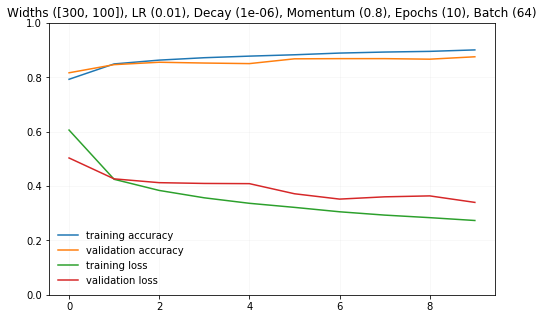

Train time: 34.47385287284851
  Accuracy: 0.8757


In [10]:
train_time, acc, model = test_model(X_train_full, y_train_full, X_test, y_test,
           widths, lr, decay, momentum, epochs, batch_size, ret_model=True)
plt.show()
print('Train time:', train_time)
print('  Accuracy:', acc)

In [11]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

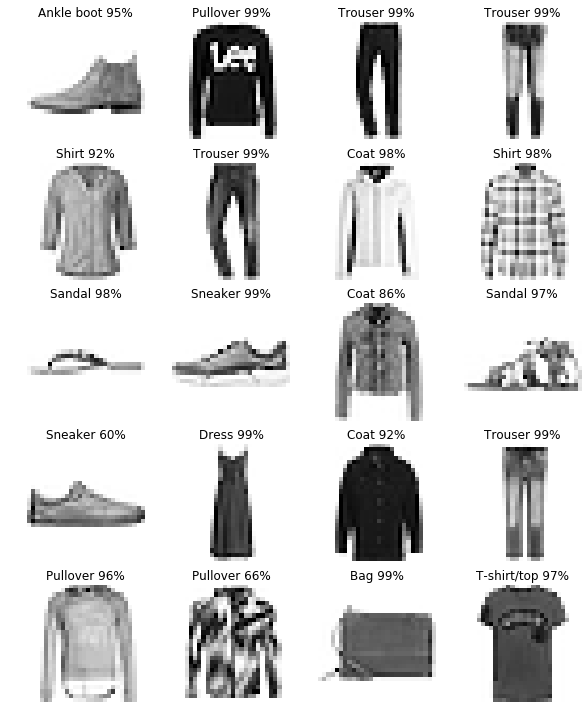

In [12]:
n = 20  # look at this many predictions
X_new = X_test[:n]
probs = model.predict(X_new)

# Plot
cols = 4
rows = (len(X_new) + cols - 1) // cols 
plt.figure(figsize=(cols * 2.5, rows * 2.5))

for i,x in enumerate(X_new):
    ax = plt.subplot(rows,cols,i+1)
    ax.imshow(x, cmap='Greys')
    best_guess = np.argmax(probs[i])
    best_prob = int(probs[i][best_guess] * 100)
    ax.set_title(class_names[best_guess] + ' {}%'.format(best_prob))
    ax.axis('off')

Now here's the top-performing model.

In [13]:
widths = [300, 300]  # widths of each hidden layer
lr = 0.01
decay = 0.0
momentum = 0.8
epochs = 10  # I accidentally produced `results.txt` with epochs=10 always, and 20 does worse
batch_size = 32

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 7s 111us/step - loss: 0.5390 - acc: 0.8111 - val_loss: 0.4741 - val_acc: 0.8280
Epoch 2/10
60000/60000 [==============================] - 7s 111us/step - loss: 0.3911 - acc: 0.8586 - val_loss: 0.3963 - val_acc: 0.8553
Epoch 3/10
60000/60000 [==============================] - 7s 110us/step - loss: 0.3504 - acc: 0.8739 - val_loss: 0.3751 - val_acc: 0.8651
Epoch 4/10
60000/60000 [==============================] - 7s 109us/step - loss: 0.3252 - acc: 0.8812 - val_loss: 0.3575 - val_acc: 0.8706
Epoch 5/10
60000/60000 [==============================] - 7s 110us/step - loss: 0.3057 - acc: 0.8872 - val_loss: 0.4133 - val_acc: 0.8564
Epoch 6/10
60000/60000 [==============================] - 7s 110us/step - loss: 0.2898 - acc: 0.8933 - val_loss: 0.3715 - val_acc: 0.8670
Epoch 7/10
60000/60000 [==============================] - 7s 111us/step - loss: 0.2778 - acc: 0.8972 - val_loss: 0.3370 - 

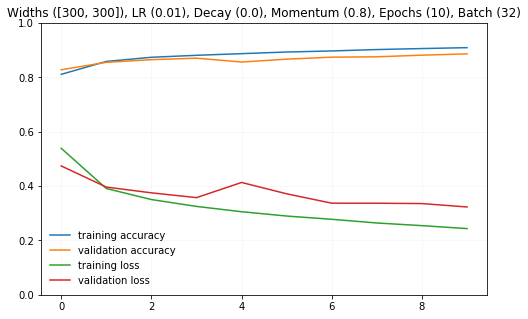

Train time: 66.02180552482605
  Accuracy: 0.8863


In [14]:
train_time, acc, model = test_model(X_train_full, y_train_full, X_test, y_test,
           widths, lr, decay, momentum, epochs, batch_size, ret_model=True)
plt.show()
print('Train time:', train_time)
print('  Accuracy:', acc)

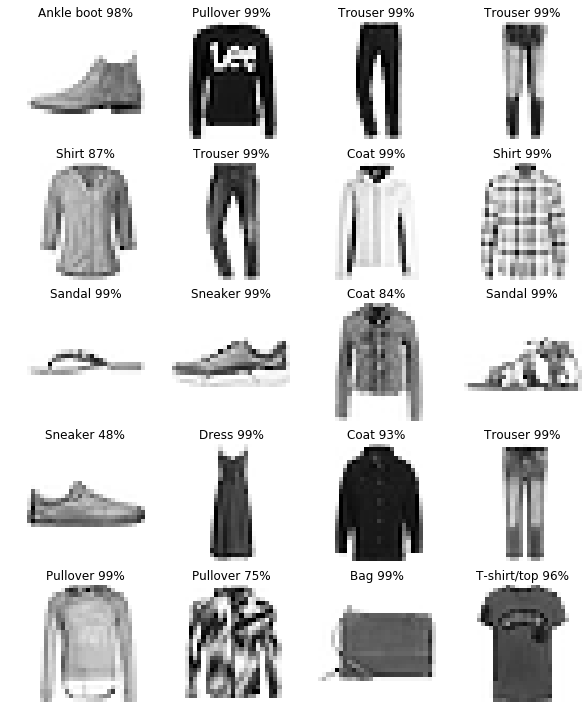

In [15]:
n = 20  # look at this many predictions
X_new = X_test[:n]
probs = model.predict(X_new)

# Plot
cols = 4
rows = (len(X_new) + cols - 1) // cols 
plt.figure(figsize=(cols * 2.5, rows * 2.5))

for i,x in enumerate(X_new):
    ax = plt.subplot(rows,cols,i+1)
    ax.imshow(x, cmap='Greys')
    best_guess = np.argmax(probs[i])
    best_prob = int(probs[i][best_guess] * 100)
    ax.set_title(class_names[best_guess] + ' {}%'.format(best_prob))
    ax.axis('off')